# Deep Learning How to Fit an Intravoxel Incoherent Motion Model to Diffusion-Weighted MRI

This notebook contains a demo of the IVIM fitting approach proposed in "Deep Learning How to Fit an Intravoxel Incoherent Motion Model to Diffusion-Weighted MRI" by Barbieri et al., 2019. A preprint of the paper can be found at: https://arxiv.org/abs/1903.00095

## Training Data

Start by creating some training data. 

**Please note:** 
- The creation of a separate training dataset is only necessary for the purpose of this notebook.
- In an actual clinical study, the network would be trained on voxels from the set of clinical images of interest. Take care to:
    - Exclude background voxels.
    - Normalize by the b=0 value (this is not stricly necessary but should facilitate training).

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import config

In [2]:
# define ivim function
def ivim(b, Dp, Dt, Fp):
    return Fp*np.exp(-b*Dp) + (1-Fp)*np.exp(-b*Dt)

In [3]:
# define b values
# b_values = np.array([0,990,995,1000,1005,1985,1990,1995])
b_values = np.array([0,10,20,60,150,300,990,1000])
# training data
num_samples = 100000
X_train = np.zeros((num_samples, len(b_values)))
for i in range(len(X_train)):
    Dp = np.random.uniform(0.01, 0.1) 0.00015， 0.0001
    Dt = np.random.uniform(0.0005, 0.002) 
    # 0.0015 0.003 diffusion of free water 
    Fp = np.random.uniform(0.1, 0.4)
    X_train[i, :] = ivim(b_values, Dp, Dt, Fp)
# add some noise
X_train_real = X_train + np.random.normal(scale=0.01, size=(num_samples, len(b_values)))
X_train_imag = np.random.normal(scale=0.01, size=(num_samples, len(b_values)))
X_train = np.sqrt(X_train_real**2 + X_train_imag**2)

In [6]:
print(X_train[9000,:])
print(X_train.shape)

[0.99231353 0.87911384 0.80167549 0.69539979 0.61618948 0.50414034
 0.22792498 0.22711584]
(100000, 8)


In [14]:
bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')
bval_list = np.unique(bval_list)
print(type(bval_list))
print(bval_list)

<class 'numpy.ndarray'>
[   5.  990.  995. 1000. 1005. 1985. 1990. 1995. 2000. 2005. 2010. 2980.
 2985. 2990. 2995. 3000. 3005. 3010.]


In [ ]:
# define b values
b_values = bval_list
# training data
num_samples = 100000
X_train = np.zeros((num_samples, len(b_values)))
for i in range(len(X_train)):
    Dp = np.random.uniform(0.01, 0.1)
    Dt = np.random.uniform(0.0005, 0.002)
    Fp = np.random.uniform(0.1, 0.4)
    X_train[i, :] = ivim(b_values, Dp, Dt, Fp)
    
# add some noise
X_train_real = X_train + np.random.normal(scale=0.01, size=(num_samples, len(b_values)))
X_train_imag = np.random.normal(scale=0.01, size=(num_samples, len(b_values)))
X_train = np.sqrt(X_train_real**2 + X_train_imag**2)

In [ ]:
print(X_train)
print(X_train.shape)

## Neural Network Training

Let's create the neural network class and instantiate it.

In [7]:
class Net(nn.Module):
    def __init__(self, b_values_no0):
        super(Net, self).__init__()

        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), 3))

    def forward(self, X):
        params = torch.abs(self.encoder(X)) # Dp, Dt, Fp
        Dp = params[:, 0].unsqueeze(1)
        Dt = params[:, 1].unsqueeze(1)
        Fp = params[:, 2].unsqueeze(1)

        X = Fp*torch.exp(-self.b_values_no0*Dp) + (1-Fp)*torch.exp(-self.b_values_no0*Dt)

        return X, Dp, Dt, Fp

In [8]:
# Network
b_values_no0 = torch.FloatTensor(b_values[1:])
net = Net(b_values_no0)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)  

Create batch queues.

In [9]:
batch_size = 128
num_batches = len(X_train) // batch_size
X_train_1 = X_train[:,1:] # exlude the b=0 value as signals are normalized
trainloader = utils.DataLoader(torch.from_numpy(X_train_1.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)


Train, this might take a few minutes.

In [ ]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

# Train
counter = 0
for epoch in range(1000): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # print('X_batch: ')
        # print(X_batch)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        if counter <= 2:
            print('[2,5]', X_pred[2,5])
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

      
    print("Loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
# Restore best model
net.load_state_dict(final_model)

## Simulated Diffusion-Weighted MR Image

Create a simulated diffusion-weighted image. The image contains three regions with different Dp, Dt, and Fp values. 

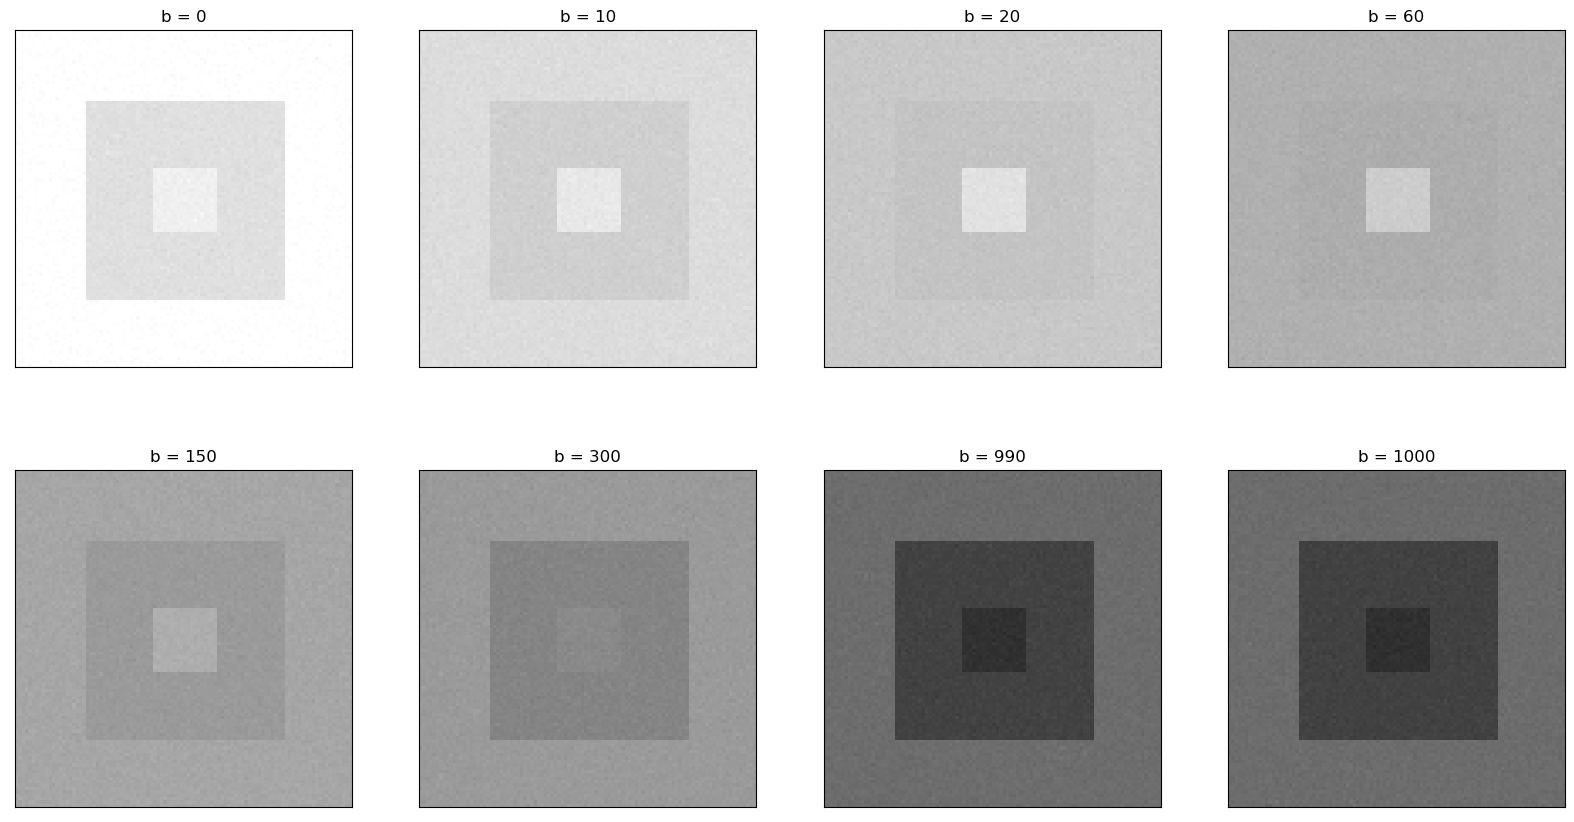

In [11]:
# define parameter values in the three regions
S0_region0, S0_region1, S0_region2 = 1500, 1400, 1600
Dp_region0, Dp_region1, Dp_region2 = 0.02, 0.04, 0.06
Dt_region0, Dt_region1, Dt_region2 = 0.0015, 0.0010, 0.0005
Fp_region0, Fp_region1, Fp_region2 = 0.1, 0.2, 0.3
# image size
sx, sy, sb = 100, 100, len(b_values)
# create image
dwi_image = np.zeros((sx, sy, sb))
Dp_truth = np.zeros((sx, sy))
Dt_truth = np.zeros((sx, sy))
Fp_truth = np.zeros((sx, sy))
# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (40 < i < 60) and (40 < j < 60):
            # region 0
            dwi_image[i, j, :] = S0_region0*ivim(b_values, Dp_region0, Dt_region0, Fp_region0)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region0, Dt_region0, Fp_region0
        elif (20 < i < 80) and (20 < j < 80):
            # region 1
            dwi_image[i, j, :] = S0_region1*ivim(b_values, Dp_region1, Dt_region1, Fp_region1)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region1, Dt_region1, Fp_region1
        else:
            # region 2
            dwi_image[i, j, :] = S0_region2*ivim(b_values, Dp_region2, Dt_region2, Fp_region2)
            
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region2, Dt_region2, Fp_region2
            
# add some noise
dwi_image_real = dwi_image + np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image_imag = np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image = np.sqrt(dwi_image_real**2 + dwi_image_imag**2)
# plot simulated diffusion weighted image
fig, ax = plt.subplots(2, 4, figsize=(20,20))
b_id = 0
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(dwi_image[:, :, b_id], cmap='gray', clim=(0, 1600))
        ax[i, j].set_title('b = ' + str(b_values[b_id]))
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        b_id += 1
plt.subplots_adjust(hspace=-0.6)
plt.show()


## Inference

Estimate IVIM parameter values for the simulated image.

In [12]:
# normalize signal
dwi_image_long = np.reshape(dwi_image, (sx*sy, sb))
S0 = np.expand_dims(dwi_image_long[:,0], axis=-1)
dwi_image_long = dwi_image_long[:,1:]/S0

net.eval()
with torch.no_grad():
    _, Dp, Dt, Fp = net(torch.from_numpy(dwi_image_long.astype(np.float32)))
    
Dp = Dp.numpy()
Dt = Dt.numpy()
Fp = Fp.numpy()

# make sure Dp is the larger value between Dp and Dt
if np.mean(Dp) < np.mean(Dt):
    Dp, Dt = Dt, Dp
    Fp = 1 - Fp

Plot parameter estimates and corresponding ground truths.

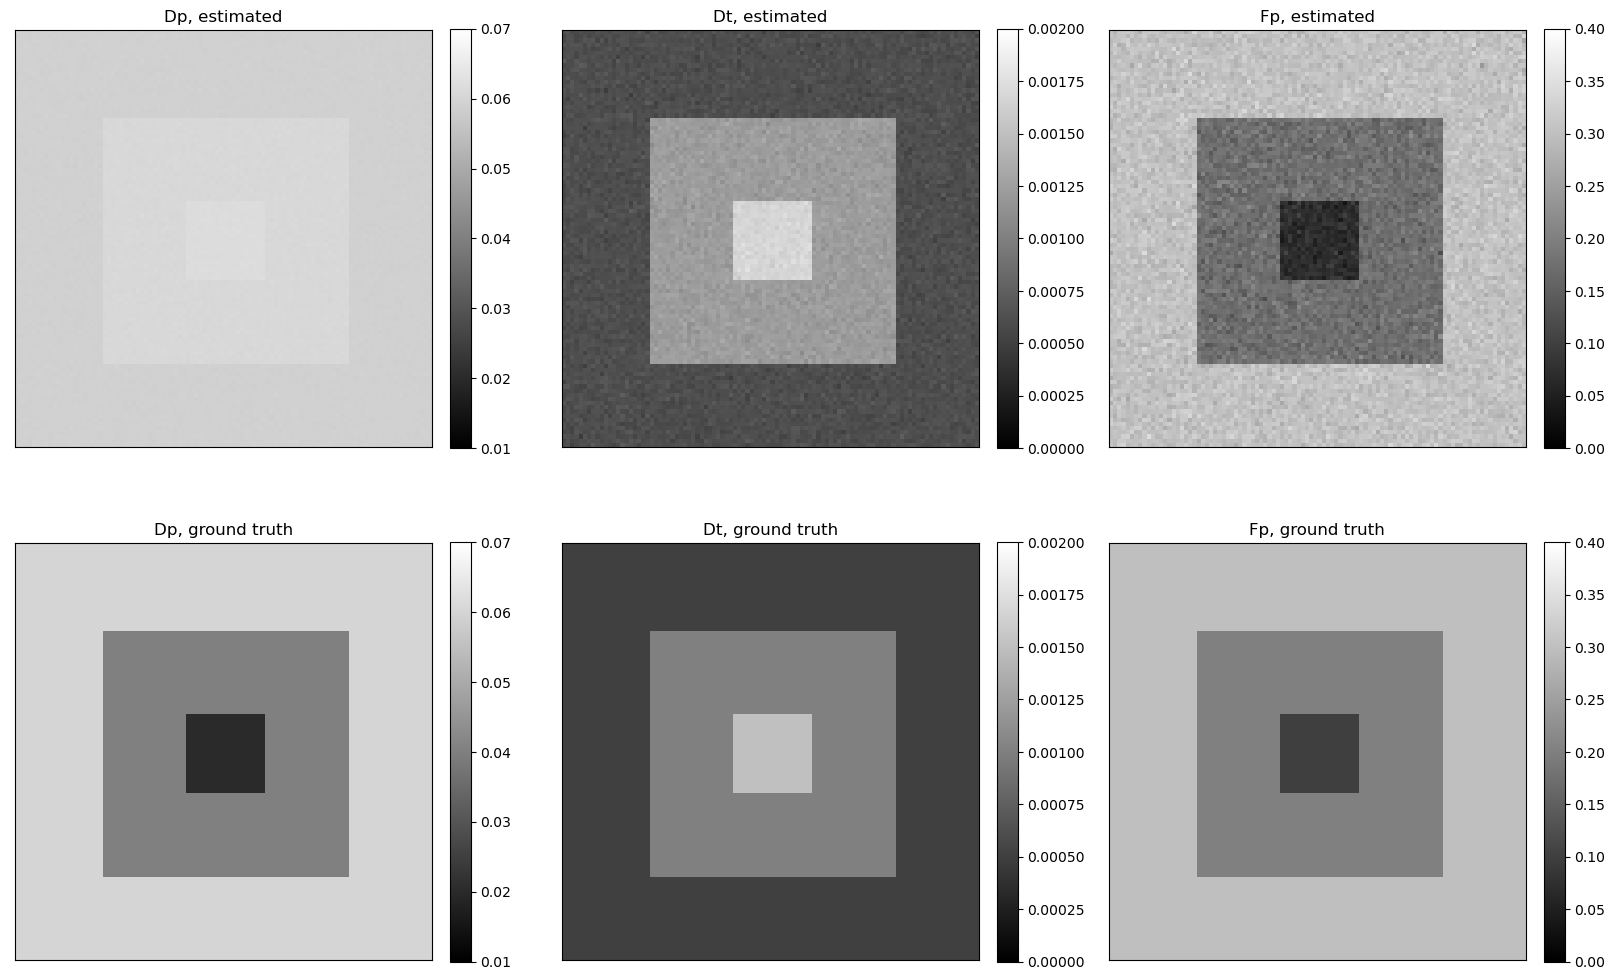

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(20,20))

Dp_plot = ax[0,0].imshow(np.reshape(Dp, (sx, sy)), cmap='gray', clim=(0.01, 0.07))
ax[0,0].set_title('Dp, estimated')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(Dp_plot, ax=ax[0,0], fraction=0.046, pad=0.04)

Dp_t_plot = ax[1,0].imshow(Dp_truth, cmap='gray', clim=(0.01, 0.07))
ax[1,0].set_title('Dp, ground truth')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(Dp_t_plot, ax=ax[1,0], fraction=0.046, pad=0.04)

Dt_plot = ax[0,1].imshow(np.reshape(Dt, (sx, sy)), cmap='gray', clim=(0, 0.002))
ax[0,1].set_title('Dt, estimated')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(Dt_plot, ax=ax[0,1],fraction=0.046, pad=0.04)

Dt_t_plot = ax[1,1].imshow(Dt_truth, cmap='gray', clim=(0, 0.002))
ax[1,1].set_title('Dt, ground truth')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(Dt_t_plot, ax=ax[1,1], fraction=0.046, pad=0.04)

Fp_plot = ax[0,2].imshow(np.reshape(Fp, (sx, sy)), cmap='gray', clim=(0, 0.4))
ax[0,2].set_title('Fp, estimated')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
fig.colorbar(Fp_plot, ax=ax[0,2],fraction=0.046, pad=0.04)

Fp_t_plot = ax[1,2].imshow(Fp_truth, cmap='gray', clim=(0, 0.4))
ax[1,2].set_title('Fp, ground truth')
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
fig.colorbar(Fp_t_plot, ax=ax[1,2], fraction=0.046, pad=0.04)

plt.subplots_adjust(hspace=-0.5)
plt.show()
